In [1]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf

In [2]:
# необходимые настройки для запуска на gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [4]:
COCO_ROOT = '/home/alex/data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=18.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [8]:
train_ds = COCO_dataset_train.train_dataset(batch_size=8, epochs=1, inp_size=256)
val_ds = COCO_dataset_val.val_dataset(batch_size=8, inp_size=256)

In [9]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out

In [10]:
# В качестве энкодера возьмём vgg-16 из исходников кераса, лишь удалив последний maxpulling для согласования
# размеров и добавив skip connections
def build_model():
    img_input = tf.keras.layers.Input((256, 256, 3))
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = tf.keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)

    out_enc_mid = x
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)

    x = aspp(x)

    x = tf.image.resize(x, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

    out_enc_mid = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')(out_enc_mid)

    x = tf.concat([x, out_enc_mid], axis=3)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)(x)

    x = tf.image.resize(x, tf.shape(img_input)[1:3], tf.image.ResizeMethod.BILINEAR)
    x = tf.nn.sigmoid(x)


    return tf.keras.Model(inputs=img_input, outputs=x)

aspp = ASPPBlock()
model = build_model()

In [10]:
# загрузим веса для энкодера, обученные на imagenet
model.load_weights('/home/alex/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

In [11]:
import matplotlib.pyplot as plt

In [12]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

In [12]:
# обучаем модель с чекпоинтами. Оказалось, "лучшая модель" сохраняется только после валидации,
# а валидацию на чекпоинтах я не делал. Будем знать
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_freq=1000,
    save_best_only=True)

model.fit(train_ds, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Train for 8014 steps, validate for 336 steps
6749/8014 [========================>.....] - ETA: 33:32 - loss: 0.4028WARNING:tensorflow:Can save best model only with val_acc available, skipping.


8014/8014 [==============================] - 12902s 2s/step - loss: 0.3906 - val_loss: 0.3184


In [17]:
model.save_weights("model_num.h5")

In [13]:
model.load_weights("model_num.h5")

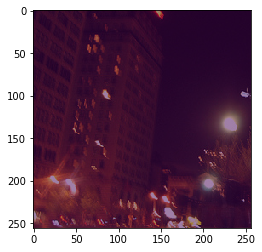

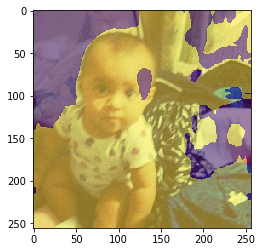

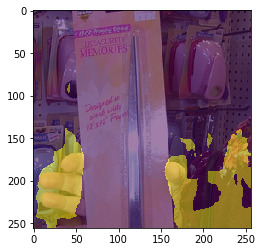

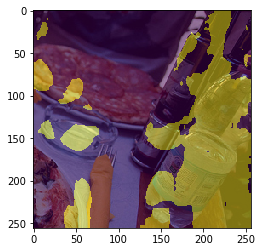

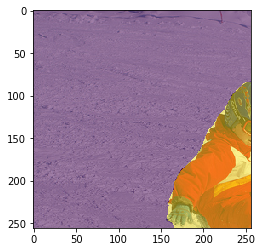

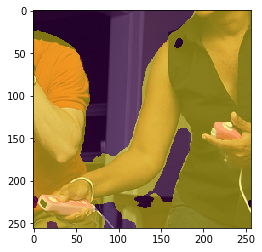

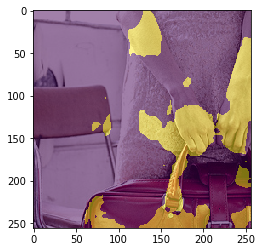

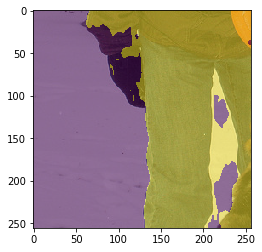

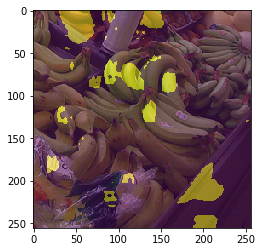

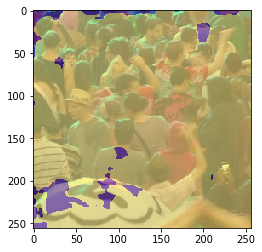

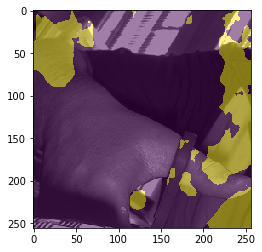

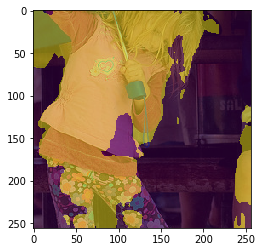

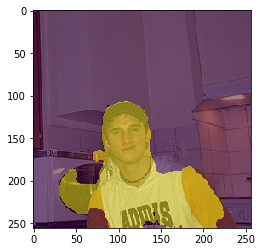

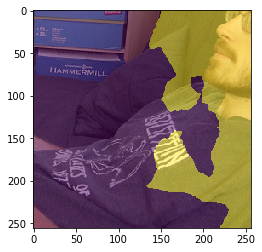

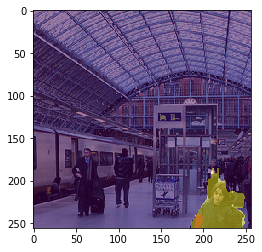

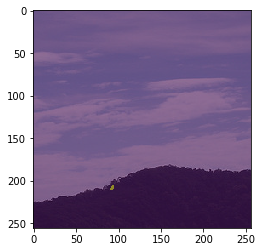

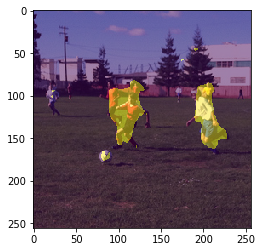

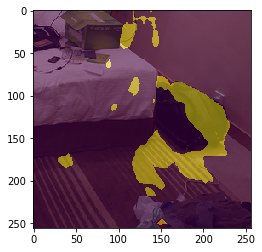

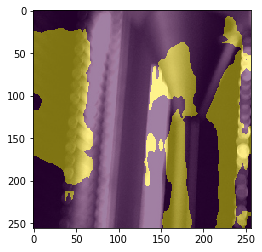

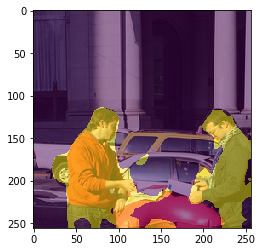

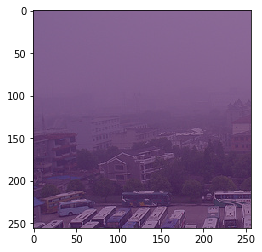

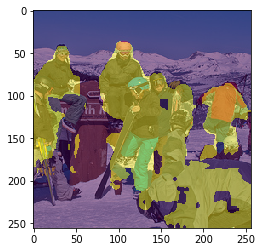

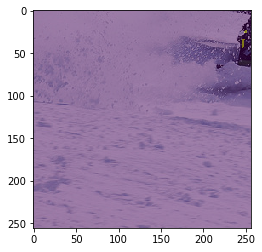

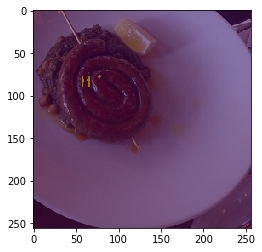

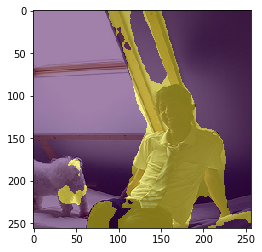

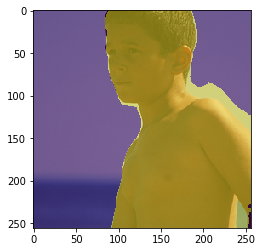

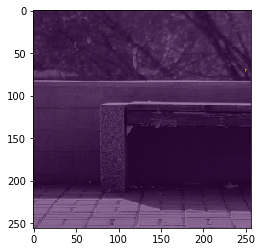

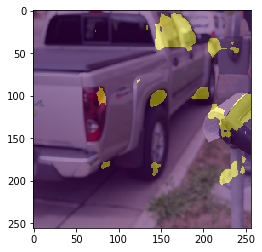

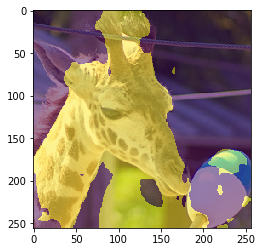

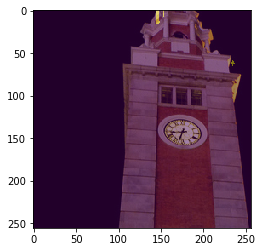

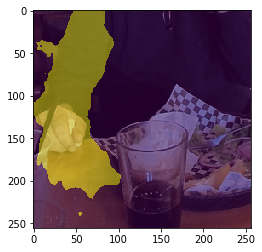

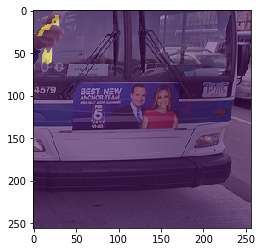

In [19]:
# Качество получилось довольно низкое, возможно одной эпохи оказалось не достаточно.
some_samples = [x[0] for x in iter(train_ds.take(32))]
for sample in some_samples:
    out = model.predict(sample[0][None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample[0]*0.5 + seg_map_clr*0.5)
    plt.show()